[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bgoujaud/PEPit/blob/master/ressources/demo/PEPit_demo_extracting_a_proof.ipynb)

# PEPit : numerical examples of worst-case analyses

This notebook provides:
- two simple examples illustrating how to extract numerical values for the dual variables to analyse **gradient descent** in the smooth and strongly convex setting.
- We show how to search for simplified versions of the proofs, if possible, by explicitly removing certain constraints from the performance estimation problem and by observing they play no role in certain performance guarantees.
- Finally, we show how to leverage those numerical findings to find a convergence proof with SymPy. More details about such strategies can be found in the repository [learning performance estimation](https://github.com/PerformanceEstimation/Learning-Performance-Estimation), from which those examples were taken.

The examples below are taken from [this blog post](https://francisbach.com/computer-aided-analyses/) and in the [habilitation thesis](https://hal.science/tel-04794552v2/file/HDR_ATaylor_V_HAL2.pdf) that contain a more mathematical introduction to performance estimation problems.

This notebook is organized as follows:
* [1. Gradient descent, distance to a solution](#example1) : numerical study of **gradient descent** for smooth strongly convex minimization, convergence in terms of $\frac{\|x_{k+1}-x_\star\|^2}{\|x_k-x_\star\|^2}$ (basic example).
* [2. Gradient descent, function value accuracy](#example2) : numerical study of **gradient descent** for smooth strongly convex minimization, convergence in terms of $\frac{f(x_{k+1})-f_\star}{f(x_{k})-f_\star}$ (more complicated example).
* [3. Function values: numerical proof simplification](#example3) : a base (greedy) approach to search for which inequalities are needed for a proof of convergence in terms of $\frac{f(x_{k+1})-f_\star}{f(x_{k})-f_\star}$.
* [4. Using SymPy for the distance analysis](#example4) : leverage the SymPy package to get a closed form solution (and proof) for the analysis of gradient descent in terms of $\frac{\|x_{k+1}-x_\star\|^2}{\|x_k-x_\star\|^2}$ (basic example).
* [5. Using SymPy for the function value accuracy analysis](#example5) : leverage the SymPy package to get a closed form solution (and proof) for the analysis of gradient descent in terms of $\frac{f(x_{k+1})-f_\star}{f(x_{k})-f_\star}$ (more technical and illustrates why step [3.](#example3) is useful/needed.
* [6. Using symbolic regression (PySR package) for guessing closed-forms](#example6)

In [1]:
# import PEPit and the required function class
from PEPit import PEP
from PEPit.functions import SmoothStronglyConvexFunction
# import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set up the smoothness and strong convexity constant for the whole notebook
L, mu = 1, .1

<a id="toc"></a>
## Table of Contents
- [1. Gradient descent, distance to a solution](#example1)
- [2. Gradient descent, function value accuracy](#example2)
- [3. Function values: numerical proof simplification](#example3)
- [4. Using SymPy for the distance analysis](#example4)
- [5. Using SymPy for the function value accuracy analysis](#example5)
- [6. Using symbolic regression (PySR)](#example6)

##  1 Gradient descent, distance to a solution <a class="anchor" id="example1"></a>

We start by a direct attempt: fix class parameters $L,\mu$ (chosen above) and experiment with different step size values $\gamma$. Verify that the obtained convergence rate is indeed smaller than one only when $\gamma\in\left(0,\frac{2}{L}\right)$. Further verify that it matches the very well-known $\max\{(1-\gamma L)^2,(1-\gamma\mu)^2\}$.

In [3]:
def wc_gradient_descent_distance(mu,L,gamma, verbose):
    # Instantiate PEP
    problem = PEP()

    # Declare a smooth convex function
    f = problem.declare_function(SmoothStronglyConvexFunction, L=L, mu=mu)
    
    # Start by defining its unique optimal point xs = x_* and corresponding function value fs = f_*
    xs = f.stationary_point()
    fs = f(xs)
    
    # Then define the starting point x0 of the algorithm
    x0 = problem.set_initial_point()
    
    # Set the initial constraint that is the distance between x0 and x^*
    problem.set_initial_condition((x0 - xs) ** 2 <= 1)
    
    # Run n steps of the GD method
    x1 = x0 - gamma * f.gradient(x0)
    
    # Set the performance metric to the function values accuracy
    problem.set_performance_metric( (x1 - xs) ** 2 )
    
    # Solve the PEP
    pepit_verbose = max(verbose, 0)
    pepit_tau = problem.solve(verbose=pepit_verbose)
    
    return pepit_tau, problem._list_of_prepared_constraints # outputs optimal value and list of constraints (with their associated dual variables)

In [4]:
verbose = 0

gamma_min, gamma_max = -1, 3
nb_gammas = 50
gamma_list = np.linspace(gamma_min,gamma_max,nb_gammas)

pepit_worst_case_value = list()
known_worst_case_value = list()

for gamma in gamma_list:
    pepit_tau, _ = wc_gradient_descent_distance(mu,L,gamma, verbose)
    pepit_worst_case_value.append(pepit_tau)
    known_worst_case_value.append(max((1-gamma*L)**2,(1-gamma*mu)**2))

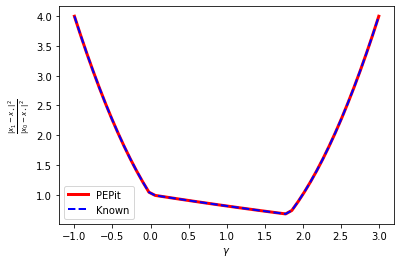

In [5]:
plt.plot(gamma_list, pepit_worst_case_value, color='red', linestyle='-', linewidth=3, label='PEPit')

plt.plot(gamma_list, known_worst_case_value, color='blue', linestyle='--', linewidth=2, label='Known')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\frac{\|x_1 - x_\star\|^2}{\|x_0 - x_\star\|^2}$')

plt.show()

One can admit that the match between PEPit's results and the known convergence rate is pretty good. For completeness, let us also extract the dual variables. The next lines examplify how to do this extraction for given values of the parameters, and we integrate it in a loop for plotting below.

In [6]:
verbose = 0
gamma = 1/L

pepit_tau, list_of_constraints = wc_gradient_descent_distance(mu,L,gamma, verbose)

nb_cons = len(list_of_constraints)

for i in range(nb_cons):
    print('Constraint \"{}\" value: {}'.format(list_of_constraints[i].get_name(),
                                               list_of_constraints[i]._dual_variable_value))

Constraint "Constraint 3" value: 0.9999999999866084
Constraint "Constraint 0" value: 0.8100001805827125
Constraint "IC_Function_0_smoothness_strong_convexity(Point_0, Point_1)" value: 1.7999998617137993
Constraint "IC_Function_0_smoothness_strong_convexity(Point_1, Point_0)" value: 1.7999998617138078


One can observe that the performance estimation problem is actually involving 4 constraints, 2 of which are of interest for us: the 3rd and 4th ones (that encode the fact the function is smooth and strongly convex). We can therefore extract their values in a loop, plot them, and expect their closed-forms to be nice. Perhaps one could even guess their values.

In [7]:
verbose = 0

gamma_min, gamma_max = -1, 3
nb_gammas = 50
gamma_list = np.linspace(gamma_min,gamma_max,nb_gammas)

pepit_worst_case_value = list()
pepit_dual_value1 = list()
pepit_dual_value2 = list()
known_worst_case_value = list()

for gamma in gamma_list:
    pepit_tau, list_of_constraints = wc_gradient_descent_distance(mu,L,gamma, verbose)
    pepit_worst_case_value.append(pepit_tau)
    known_worst_case_value.append(max((1-gamma*L)**2,(1-gamma*mu)**2))
    pepit_dual_value1.append(list_of_constraints[2]._dual_variable_value)
    pepit_dual_value2.append(list_of_constraints[3]._dual_variable_value)

Playing a bit with candidate expressions, one can guess a closed-form for the multipliers (which happen to be always equal): $\lambda=2|\gamma| \rho(\gamma)$ with $\rho(\gamma)=\max\{|1-\gamma L|,|1-\gamma\mu|\}$.

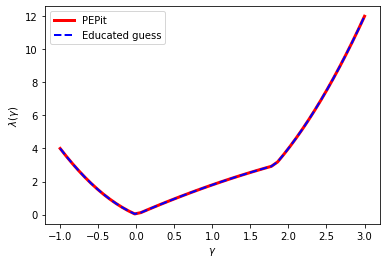

In [8]:
candidate_lambda = [ max(abs(1-gamma*L),abs(1-gamma*mu))*2*abs(gamma) for gamma in gamma_list ]

plt.plot(gamma_list, pepit_dual_value1, color='red', linestyle='-', linewidth=3, label='PEPit')
plt.plot(gamma_list, candidate_lambda, color='blue', linestyle='--', linewidth=2, label='Educated guess')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\lambda(\gamma)$')

plt.show()

Section [4](#example4) below explores how to transform that into a formal mathematical proof (that include replacing the actual guessing game by formal mathematical steps). In the meantime, we explore a case where things are directly less convenient, that of function values. In fact, this slightly more complicated problem already show a typical feature appearing in computer-aided analyses: non-uniqueness of the proofs. This might seem like a good thing (in fact, it is, in many aspects), but it actually renders the formal translation and search more painful, as the numerical solvers actually generally do not provide the simplest proofs possible, but rather combinations of them and fail providing the *sparse* (and likely simpler) ones.

<div align="right"><a href="#toc">↩ Back to TOC</a></div>

## 2 Gradient descent, function value accuracy <a class="anchor" id="example2"></a>

Let us start with the exact same exercise, but now by changing the specific quantity under our radar to function values. Practically speaking, this means changing both the performance metric and the initial condition in the previous code. Executing the code in the same fashion as before, we observe the exact same worst-case ratios.

In [9]:
def wc_gradient_descent_function_values(mu,L,gamma, verbose):
    # Instantiate PEP
    problem = PEP()

    # Declare a smooth convex function
    f = problem.declare_function(SmoothStronglyConvexFunction, L=L, mu=mu)
    
    # Start by defining its unique optimal point xs = x_* and corresponding function value fs = f_*
    xs = f.stationary_point()
    fs = f(xs)
    
    # Then define the starting point x0 of the algorithm
    x0 = problem.set_initial_point()
    
    # Set the initial constraint that is the distance between x0 and x^*
    problem.set_initial_condition( f(x0) - fs <= 1)
    
    # Run n steps of the GD method
    x1 = x0 - gamma * f.gradient(x0)
    
    # Set the performance metric to the function values accuracy
    problem.set_performance_metric( f(x1) - fs )
    
    # Solve the PEP
    pepit_verbose = max(verbose, 0)
    pepit_tau = problem.solve(verbose=pepit_verbose)
    
    return pepit_tau, problem._list_of_prepared_constraints # outputs optimal value and list of constraints (with their associated dual variables)

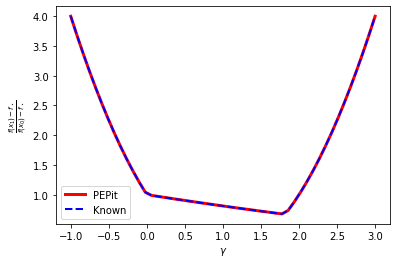

In [10]:
verbose = 0

gamma_min, gamma_max = -1, 3
nb_gammas = 50
gamma_list = np.linspace(gamma_min,gamma_max,nb_gammas)

pepit_worst_case_value = list()
known_worst_case_value = list()

for gamma in gamma_list:
    pepit_tau, _ = wc_gradient_descent_function_values(mu,L,gamma, verbose)
    pepit_worst_case_value.append(pepit_tau)
    known_worst_case_value.append(max((1-gamma*L)**2,(1-gamma*mu)**2))
    
plt.plot(gamma_list, pepit_worst_case_value, color='red', linestyle='-', linewidth=3, label='PEPit')

plt.plot(gamma_list, known_worst_case_value, color='blue', linestyle='--', linewidth=2, label='Known')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\frac{f(x_1) - f_\star}{f(x_0) - f_\star}$')

plt.show()

However, a bad surprise appears when inspecting the problem: there are actually more constraints, and hence possibly more dual multipliers to be identified. We do not describe here the reason for this difference (more constraints, explained at length, e.g., in [this blog post](https://francisbach.com/computer-aided-analyses/) or this [habilitation thesis](https://hal.science/tel-04794552v2/file/HDR_ATaylor_V_HAL2.pdf)) and instead focus on the consequences.

In [11]:
verbose = 0
gamma = 1/L

pepit_tau, list_of_constraints = wc_gradient_descent_function_values(mu,L,gamma, verbose)

nb_cons = len(list_of_constraints)

for i in range(nb_cons):
    print('Constraint \"{}\" value: {}'.format(list_of_constraints[i].get_name(),
                                               list_of_constraints[i]._dual_variable_value))

Constraint "Constraint 7" value: 1.000000000000004
Constraint "Constraint 0" value: 0.8099999986909497
Constraint "IC_Function_0_smoothness_strong_convexity(Point_0, Point_1)" value: 0.07413167584202415
Constraint "IC_Function_0_smoothness_strong_convexity(Point_0, Point_2)" value: 0.11586832639046385
Constraint "IC_Function_0_smoothness_strong_convexity(Point_1, Point_0)" value: 1.1349094168952335e-09
Constraint "IC_Function_0_smoothness_strong_convexity(Point_1, Point_2)" value: 1.0428149257255546
Constraint "IC_Function_0_smoothness_strong_convexity(Point_2, Point_0)" value: 1.2819965105035798e-09
Constraint "IC_Function_0_smoothness_strong_convexity(Point_2, Point_1)" value: 0.1586832515672777


To get a clearer picture, let us plot all those values as a function of $\gamma$ again.

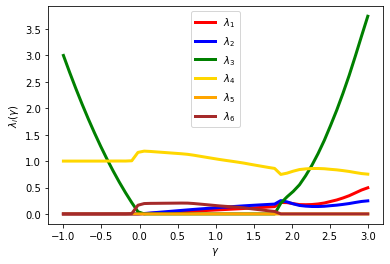

In [12]:
verbose = 0

gamma_min, gamma_max = -1, 3
nb_gammas = 50
gamma_list = np.linspace(gamma_min,gamma_max,nb_gammas)

pepit_worst_case_value = list()
pepit_dual_value1 = list()
pepit_dual_value2 = list()
pepit_dual_value3 = list()
pepit_dual_value4 = list()
pepit_dual_value5 = list()
pepit_dual_value6 = list()
known_worst_case_value = list()

for gamma in gamma_list:
    pepit_tau, list_of_constraints = wc_gradient_descent_function_values(mu,L,gamma, verbose)
    pepit_worst_case_value.append(pepit_tau)
    known_worst_case_value.append(max((1-gamma*L)**2,(1-gamma*mu)**2))
    pepit_dual_value1.append(list_of_constraints[2]._dual_variable_value)
    pepit_dual_value2.append(list_of_constraints[3]._dual_variable_value)
    pepit_dual_value3.append(list_of_constraints[4]._dual_variable_value)
    pepit_dual_value4.append(list_of_constraints[5]._dual_variable_value)
    pepit_dual_value5.append(list_of_constraints[6]._dual_variable_value)
    pepit_dual_value6.append(list_of_constraints[7]._dual_variable_value)
    
    
plt.plot(gamma_list, pepit_dual_value1, color='red', linestyle='-', linewidth=3, label=r'$\lambda_1$')
plt.plot(gamma_list, pepit_dual_value2, color='blue', linestyle='-', linewidth=3, label=r'$\lambda_2$')
plt.plot(gamma_list, pepit_dual_value3, color='green', linestyle='-', linewidth=3, label=r'$\lambda_3$')
plt.plot(gamma_list, pepit_dual_value4, color='gold', linestyle='-', linewidth=3, label=r'$\lambda_4$')
plt.plot(gamma_list, pepit_dual_value5, color='orange', linestyle='-', linewidth=3, label=r'$\lambda_5$')
plt.plot(gamma_list, pepit_dual_value6, color='brown', linestyle='-', linewidth=3, label=r'$\lambda_6$')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\lambda_i(\gamma)$')

plt.show()

Well, guessing closed-forms appears like a much more challenging game now. The next section illustrates that one can actually simplify this picture simply by removing certain of the constraints (or equivalently by forcing their multipliers to be zero).

<div align="right"><a href="#toc">↩ Back to TOC</a></div>

##  3 Function values: numerical proof simplification <a class="anchor" id="example3"></a>

The game for this section consists in forcing certain multipliers to be zero (deactivating constraints) while keeping the same optimal value. In other words, we search for possibly *sparse* proofs. For doing that, we must experiment with solve/resolve the PEP with different constraints patterns. In PEPit, this can be done through the *prepare_problem* command (instead of solve) as follows:

In [13]:
def wc_gradient_descent_function_values_prepare(mu,L,gamma, verbose):
    # Instantiate PEP
    problem = PEP()

    # Declare a smooth convex function
    f = problem.declare_function(SmoothStronglyConvexFunction, L=L, mu=mu)
    
    # Start by defining its unique optimal point xs = x_* and corresponding function value fs = f_*
    xs = f.stationary_point()
    fs = f(xs)
    
    # Then define the starting point x0 of the algorithm
    x0 = problem.set_initial_point()
    
    # Set the initial constraint that is the distance between x0 and x^*
    problem.set_initial_condition( f(x0) - fs <= 1)
    
    # Run n steps of the GD method
    x1 = x0 - gamma * f.gradient(x0)
    
    # Set the performance metric to the function values accuracy
    problem.set_performance_metric( f(x1) - fs )
    
    # Output prepared problem
    pepit_verbose = max(verbose, 0)
    problem._prepare_constraints(verbose=pepit_verbose)
    
    return problem

PEP_GD = wc_gradient_descent_function_values_prepare(mu,L,gamma=1/L, verbose=1)

(PEPit) Setting up the problem: performance measure is the minimum of 1 element(s)
(PEPit) Setting up the problem: Adding initial conditions and general constraints ...
(PEPit) Setting up the problem: initial conditions and general constraints (1 constraint(s) added)
(PEPit) Setting up the problem: interpolation conditions for 1 function(s)
			Function 1 : Adding 6 scalar constraint(s) ...
			Function 1 : 6 scalar constraint(s) added
(PEPit) Setting up the problem: additional constraints for 0 function(s)


We can now interactively iterate between solving the problem and activating/deactivating constraints, and the goal is to identify a minimal number of constraints that allows recovering the same optimal problem value. Let us start by solving the original problem.

In [14]:
# Solve the original problem and output the dual variable values

PEP_GD.solve(verbose = 1)
list_of_constraints = PEP_GD._list_of_prepared_constraints
nb_cons = len(list_of_constraints)

for i in range(nb_cons):
    print('Constraint \"{}\" value: {}'.format(list_of_constraints[i].get_name(),
                                               list_of_constraints[i]._dual_variable_value))
    

(PEPit) Setting up the problem: size of the Gram matrix: 4x4
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (wrapper:cvxpy, solver: SCS); optimal value: 0.8099999973549602
(PEPit) Primal feasibility check:
		The solver found a Gram matrix that is positive semi-definite
		All the primal scalar constraints are verified up to an error of 2.02780943356351e-08
(PEPit) Dual feasibility check:
		The solver found a residual matrix that is positive semi-definite up to an error of 2.7515637538840285e-16
		All the dual scalar values associated with inequality constraints are nonnegative
(PEPit) The worst-case guarantee proof is perfectly reconstituted up to an error of 5.729466262983668e-09
(PEPit) Final upper bound (dual): 0.8099999986909497 and lower bound (primal example): 0.8099999973549602 
(PEPit) Duality gap: absolute: 1.3359895412179412e-09 and relative: 1.649369809358753e-09
Constraint "Constraint 7" value: 1.000000000000004
Constraint "Constraint 0" valu

The corresponding optimal value matches what we would expect. Let us now deactivate some constraints and observe the result. We start with the first interpolation constraint (third constraint in the list) as follows:

In [15]:
# Solve the problem with the first interpolation constraint deactivated

list_of_constraints[2].deactivate()

PEP_GD.solve(verbose = 1)
for i in range(nb_cons):
    print('Constraint \"{}\" dual value: {} [activated? {}]'.format(list_of_constraints[i].get_name(),
                                                                    list_of_constraints[i]._dual_variable_value,
                                                                    list_of_constraints[i].activated))
    

(PEPit) Setting up the problem: size of the Gram matrix: 4x4
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (wrapper:cvxpy, solver: SCS); optimal value: 0.8099959237526846
(PEPit) Postprocessing: solver's output is not entirely feasible (smallest eigenvalue of the Gram matrix is: -7.95e-06 < 0).
 Small deviation from 0 may simply be due to numerical error. Big ones should be deeply investigated.
 In any case, from now the provided values of parameters are based on the projection of the Gram matrix onto the cone of symmetric semi-definite matrix.
(PEPit) Primal feasibility check:
		The solver found a Gram matrix that is positive semi-definite up to an error of 7.950263779793486e-06
		All the primal scalar constraints are verified up to an error of 2.02780943356351e-08
(PEPit) Dual feasibility check:
		The solver found a residual matrix that is positive semi-definite up to an error of 1.294938016578548e-16
		All the dual scalar values associated with ineq

Good surprise: the same numerical bound can be achieved without using the first interpolation constraint... let's try to be more aggressive and deactivate more constraints.

In [16]:
# Solve the problem with the first interpolation constraint deactivated

list_of_constraints[3].deactivate()
list_of_constraints[4].deactivate()
list_of_constraints[5].deactivate()

PEP_GD.solve(verbose = 1)
for i in range(nb_cons):
    print('Constraint \"{}\" dual value: {} [activated? {}]'.format(list_of_constraints[i].get_name(),
                                                                    list_of_constraints[i]._dual_variable_value,
                                                                    list_of_constraints[i].activated))
    

(PEPit) Setting up the problem: size of the Gram matrix: 4x4
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: unbounded (wrapper:cvxpy, solver: SCS); optimal value: None
(PEPit) Problem issue: PEPit didn't find any nontrivial worst-case guarantee. It seems that the optimal value of your problem is unbounded.
Constraint "Constraint 7" dual value: 0.0 [activated? True]
Constraint "Constraint 0" dual value: 0.0 [activated? True]
Constraint "IC_Function_0_smoothness_strong_convexity(Point_0, Point_1)" dual value: 0.0 [activated? False]
Constraint "IC_Function_0_smoothness_strong_convexity(Point_0, Point_2)" dual value: 0.0 [activated? False]
Constraint "IC_Function_0_smoothness_strong_convexity(Point_1, Point_0)" dual value: 0.0 [activated? False]
Constraint "IC_Function_0_smoothness_strong_convexity(Point_1, Point_2)" dual value: 0.0 [activated? False]
Constraint "IC_Function_0_smoothness_strong_convexity(Point_2, Point_0)" dual value: 0.0 [activated? True]
Constrai

This was too much. We need to reactivate some.

In [17]:
# Solve the problem with the first interpolation constraint deactivated

list_of_constraints[3].activate()
list_of_constraints[5].activate()

PEP_GD.solve(verbose = 1)
for i in range(nb_cons):
    print('Constraint \"{}\" dual value: {} [activated? {}]'.format(list_of_constraints[i].get_name(),
                                                                    list_of_constraints[i]._dual_variable_value,
                                                                    list_of_constraints[i].activated))
    

(PEPit) Setting up the problem: size of the Gram matrix: 4x4
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (wrapper:cvxpy, solver: SCS); optimal value: 0.8099888053087226
(PEPit) Postprocessing: solver's output is not entirely feasible (smallest eigenvalue of the Gram matrix is: -8.97e-06 < 0).
 Small deviation from 0 may simply be due to numerical error. Big ones should be deeply investigated.
 In any case, from now the provided values of parameters are based on the projection of the Gram matrix onto the cone of symmetric semi-definite matrix.
(PEPit) Primal feasibility check:
		The solver found a Gram matrix that is positive semi-definite up to an error of 8.969189465201078e-06
		All the primal scalar constraints are verified up to an error of 2.02780943356351e-08
(PEPit) Dual feasibility check:
		The solver found a residual matrix that is positive semi-definite
		All the dual scalar values associated with inequality constraints are nonnegative
(PEPi

After a bit of experiment, one can arrive to the following pattern

In [18]:
# Solve the problem with the first interpolation constraint deactivated

list_of_constraints[2].activate()
list_of_constraints[3].activate()
list_of_constraints[5].activate()
list_of_constraints[4].deactivate()
list_of_constraints[6].deactivate()
list_of_constraints[7].deactivate()

PEP_GD.solve(verbose = 1)
for i in range(nb_cons):
    print('Constraint \"{}\" dual value: {} [activated? {}]'.format(list_of_constraints[i].get_name(),
                                                                    list_of_constraints[i]._dual_variable_value,
                                                                    list_of_constraints[i].activated))
    

(PEPit) Setting up the problem: size of the Gram matrix: 4x4
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (wrapper:cvxpy, solver: SCS); optimal value: 0.8100000003376879
(PEPit) Postprocessing: solver's output is not entirely feasible (smallest eigenvalue of the Gram matrix is: -6.16e-10 < 0).
 Small deviation from 0 may simply be due to numerical error. Big ones should be deeply investigated.
 In any case, from now the provided values of parameters are based on the projection of the Gram matrix onto the cone of symmetric semi-definite matrix.
(PEPit) Primal feasibility check:
		The solver found a Gram matrix that is positive semi-definite up to an error of 6.157372501933532e-10
		All the primal scalar constraints are verified up to an error of 2.02780943356351e-08
(PEPit) Dual feasibility check:
		The solver found a residual matrix that is positive semi-definite up to an error of 3.214747989495667e-16
		All the dual scalar values associated with ineq

Let us verify that this pattern of inequalities works throughout the whole range of step sizes $\gamma$.

In [19]:
def wc_gradient_descent_function_values_sparse_proof(mu,L,gamma, verbose):
    # Instantiate PEP
    problem = PEP()

    # Declare a smooth convex function
    f = problem.declare_function(SmoothStronglyConvexFunction, L=L, mu=mu)
    
    # Start by defining its unique optimal point xs = x_* and corresponding function value fs = f_*
    xs = f.stationary_point()
    fs = f(xs)
    
    # Then define the starting point x0 of the algorithm
    x0 = problem.set_initial_point()
    
    # Set the initial constraint that is the distance between x0 and x^*
    problem.set_initial_condition( f(x0) - fs <= 1)
    
    # Run n steps of the GD method
    x1 = x0 - gamma * f.gradient(x0)
    
    # Set the performance metric to the function values accuracy
    problem.set_performance_metric( f(x1) - fs )
    
    # Output prepared problem
    pepit_verbose = max(verbose, 0)
    problem._prepare_constraints(verbose=pepit_verbose)
    problem._list_of_prepared_constraints[4].deactivate()
    problem._list_of_prepared_constraints[6].deactivate()
    problem._list_of_prepared_constraints[7].deactivate()
    
    pepit_tau = problem.solve(verbose=pepit_verbose)
    
    return pepit_tau, problem._list_of_prepared_constraints


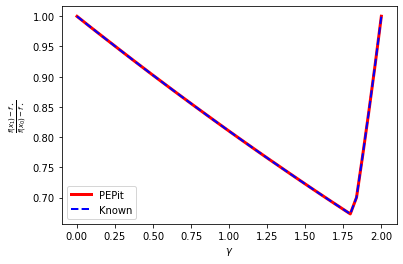

In [20]:
verbose = 0

gamma_min, gamma_max = 0.001, 2 # only test the step sizes of interest here
nb_gammas = 50
gamma_list = np.linspace(gamma_min,gamma_max,nb_gammas)

pepit_worst_case_value = list()
known_worst_case_value = list()

for gamma in gamma_list:
    pepit_tau, _ = wc_gradient_descent_function_values_sparse_proof(mu,L,gamma, verbose)
    pepit_worst_case_value.append(pepit_tau)
    known_worst_case_value.append(max((1-gamma*L)**2,(1-gamma*mu)**2))
    
plt.plot(gamma_list, pepit_worst_case_value, color='red', linestyle='-', linewidth=3, label='PEPit')

plt.plot(gamma_list, known_worst_case_value, color='blue', linestyle='--', linewidth=2, label='Known')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\frac{f(x_1) - f_\star}{f(x_0) - f_\star}$')

plt.show()

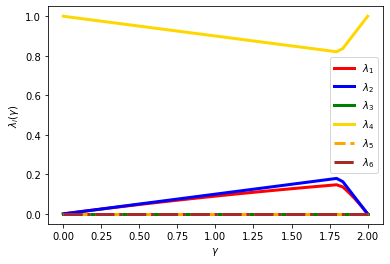

In [21]:
verbose = 0

gamma_min, gamma_max = 0.001, 2
nb_gammas = 50
gamma_list = np.linspace(gamma_min,gamma_max,nb_gammas)

pepit_worst_case_value = list()
pepit_dual_value1 = list()
pepit_dual_value2 = list()
pepit_dual_value3 = list()
pepit_dual_value4 = list()
pepit_dual_value5 = list()
pepit_dual_value6 = list()
known_worst_case_value = list()

for gamma in gamma_list:
    pepit_tau, list_of_constraints = wc_gradient_descent_function_values_sparse_proof(mu,L,gamma, verbose)
    pepit_worst_case_value.append(pepit_tau)
    known_worst_case_value.append(max((1-gamma*L)**2,(1-gamma*mu)**2))
    pepit_dual_value1.append(list_of_constraints[2]._dual_variable_value)
    pepit_dual_value2.append(list_of_constraints[3]._dual_variable_value)
    pepit_dual_value3.append(list_of_constraints[4]._dual_variable_value)
    pepit_dual_value4.append(list_of_constraints[5]._dual_variable_value)
    pepit_dual_value5.append(list_of_constraints[6]._dual_variable_value)
    pepit_dual_value6.append(list_of_constraints[7]._dual_variable_value)
    
    
plt.plot(gamma_list, pepit_dual_value1, color='red', linestyle='-', linewidth=3, label=r'$\lambda_1$')
plt.plot(gamma_list, pepit_dual_value2, color='blue', linestyle='-', linewidth=3, label=r'$\lambda_2$')
plt.plot(gamma_list, pepit_dual_value3, color='green', linestyle='-', linewidth=3, label=r'$\lambda_3$')
plt.plot(gamma_list, pepit_dual_value4, color='gold', linestyle='-', linewidth=3, label=r'$\lambda_4$')
plt.plot(gamma_list, pepit_dual_value5, color='orange', linestyle='--', linewidth=3, label=r'$\lambda_5$')
plt.plot(gamma_list, pepit_dual_value6, color='brown', linestyle='-.', linewidth=3, label=r'$\lambda_6$')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\lambda_i(\gamma)$')

plt.show()

... much better! one can actually even fit; defining $\rho(\gamma)=\max\{|1-\gamma L|,|1-\gamma\mu|\}$, we find:
* $\lambda_1(\gamma)= (1-\rho(\gamma))\rho(\gamma)$,
* $\lambda_2 (\gamma)=  1-\rho(\gamma)$,
* $\lambda_4 (\gamma)= \rho(\gamma)$.

Those results, along with the corresponding proofs, are presented in [here, Theorem 3.3](https://arxiv.org/pdf/1705.04398), a numerical comparison is provided just below.
In the next sections, we provide a constructive few way to find such expressions beyond guessing.

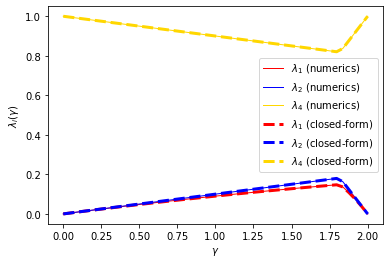

In [22]:
rho = np.array([ max(abs(1-gamma*L),abs(1-gamma*mu)) for gamma in gamma_list ])
plt.plot(gamma_list, pepit_dual_value1, color='red', linestyle='-', linewidth=1, label=r'$\lambda_1$ (numerics)')
plt.plot(gamma_list, pepit_dual_value2, color='blue', linestyle='-', linewidth=1, label=r'$\lambda_2$ (numerics)')
plt.plot(gamma_list, pepit_dual_value4, color='gold', linestyle='-', linewidth=1, label=r'$\lambda_4$ (numerics)')
plt.plot(gamma_list, (1-rho)*rho, color='red', linestyle='--', linewidth=3, label=r'$\lambda_1$ (closed-form)')
plt.plot(gamma_list, 1-rho, color='blue', linestyle='--', linewidth=3, label=r'$\lambda_2$ (closed-form)')
plt.plot(gamma_list, rho, color='gold', linestyle='--', linewidth=3, label=r'$\lambda_4$ (closed-form)')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\lambda_i(\gamma)$')

plt.show()

<div align="right"><a href="#toc">↩ Back to TOC</a></div>

## 4 Using SymPy for the distance analysis <a class="anchor" id="example4"></a>

This section requires SymPy (!pip install sympy)

In [23]:
import sympy as sm

# create symbols for the problem parameters:
L = sm.Symbol('L')
mu = sm.Symbol('mu')
gamma = sm.Symbol('gamma')

# create symbols for the "primal" variables:
x0 = sm.Symbol('x0')
g0 = sm.Symbol('g0')
f0 = sm.Symbol('f0')
xs = 0 # wlog, x_* = 0
gs = 0 # constraint g_* = 0
fs = 0 # wlog, f_* = 0
x1 = x0 - gamma * g0 # define x1 using previous symbols:

# create symbols for the "dual" variables
rho = sm.Symbol('rho')
l1 = sm.Symbol('lambda_1')
l2 = sm.Symbol('lambda_2')


# the two interpolation constraints in the form "constraint <= 0"
constraint1 = f0 - fs + g0*(xs-x0) + 1/2/L * g0**2 + mu/(2*(1-mu/L)) * (x0-xs-1/L*g0)**2
constraint2 = fs - f0 + 1/2/L * g0**2 + mu/(2*(1-mu/L)) * (x0-xs-1/L*g0)**2
# the objective and the "initial condition" constraint: (also in the form "constraint <= 0")
primal_objective = (x1-xs)**2
initial_condition = (x0-xs)**2-1

# Lagrangian:
Lagrangian = - l1*constraint1 - l2*constraint2 - rho * initial_condition + primal_objective

# This is the LMI:
LMI = sm.simplify(sm.hessian( -Lagrangian , (x0,g0))/2) 
LMI

Matrix([
[(L*lambda_1*mu/2 + L*lambda_2*mu/2 + (L - mu)*(rho - 1))/(L - mu),         (-L*lambda_1/2 + gamma*(L - mu) - lambda_2*mu/2)/(L - mu)],
[        (-L*lambda_1/2 + gamma*(L - mu) - lambda_2*mu/2)/(L - mu), (4*gamma**2*(-L + mu) + 2.0*lambda_1 + 2.0*lambda_2)/(4*(L - mu))]])

In [24]:
# This is the linear constraint ==0 in the LMI
LinearConst = sm.simplify(sm.diff(-Lagrangian,f0))

LinearConst # show linear constraint (==0)

lambda_1 - lambda_2

In [25]:
# For getting the same LMI as in the document, substitute l2 by l1 and simplify
LMI_simplified = sm.simplify(LMI.subs(l2,l1))

LMI_simplified # show the LMI (>=0)

Matrix([
[            (L*lambda_1*mu + (L - mu)*(rho - 1))/(L - mu), (-L*lambda_1/2 + gamma*(L - mu) - lambda_1*mu/2)/(L - mu)],
[(-L*lambda_1/2 + gamma*(L - mu) - lambda_1*mu/2)/(L - mu),                  (gamma**2*(-L + mu) + lambda_1)/(L - mu)]])

In [26]:
candidate_rho=sm.solve(LMI_simplified.det(),rho)
candidate_rho[0]


lambda_1*(4*L*gamma**2*mu - 4*L*gamma + L*lambda_1 - 4*gamma*mu - lambda_1*mu + 4)/(4*(-L*gamma**2 + gamma**2*mu + lambda_1))

There are two possibilities for choosing $\lambda_1$:

- so that the LMI is rank defficient (i.e., solution is on the boundary of the PSD cone),
- so that the LMI is full rank. Minimize $\rho$ wrt $\lambda_1$ and verify feasibility of the LMI.

Experimenting with the numerics, one can observe that the rank of the LMI is one for most choices of $\gamma$, let's focus on the second possibility.


In [27]:
drho=sm.simplify(sm.diff(candidate_rho[0],l1)) #differentiate $\rho$ with respect to lambda_1
l1sol=sm.solve(drho,l1) # solve drho/dlambda_1 == 0 in lambda1
l1sol # show the two possibilities!

[2*gamma*(L*gamma - 1), 2*gamma*(-gamma*mu + 1)]

The corresponding "final" expressions for that must be checked are therefore:

In [28]:
exprrho1=sm.simplify(candidate_rho[0].subs(l1,l1sol[0]))
exprrho2=sm.simplify(candidate_rho[0].subs(l1,l1sol[1]))

[exprrho1.factor(), exprrho2.factor()]

[(L*gamma - 1)**2, (gamma*mu - 1)**2]

... and we are done!

<div align="right"><a href="#toc">↩ Back to TOC</a></div>

## 5 Using SymPy for the function value accuracy analysis <a class="anchor" id="example5"></a>

... same game with the already-simplified LMI. But using a few shortcuts.

In [29]:
import sympy as sm

# create symbols for the problem parameters:
L = sm.Symbol('L')
mu = sm.Symbol('mu')
gamma = 1/L

# create symbols for the "primal" variables:
x0 = sm.Symbol('x0')
g0 = sm.Symbol('g0')
g1 = sm.Symbol('g1')
f0 = sm.Symbol('f0')
f1 = sm.Symbol('f1')
xs = 0 # wlog, x_* = 0
gs = 0 # constraint g_* = 0
fs = 0 # wlog, f_* = 0
x1 = x0 - gamma * g0 # define x1 using previous symbols:

# create symbols for the "dual" variables
rho = sm.Symbol('rho')
l1 = sm.Symbol('lambda_1')
l2 = sm.Symbol('lambda_2')
l4 = sm.Symbol('lambda_4')


# the two interpolation constraints in the form "constraint <= 0"
constraint1 = f0 - fs + g0*(xs-x0) + 1/2/L * g0**2 + mu/(2*(1-mu/L)) * (x0-xs-1/L*g0)**2
constraint2 = f1 - fs + g1*(xs-x1) + 1/2/L * g1**2 + mu/(2*(1-mu/L)) * (x1-xs-1/L*g1)**2
constraint4 = f1 - f0 + g1*(x0-x1) + 1/2/L * (g0-g1)**2 + mu/(2*(1-mu/L)) * (x1-x0-1/L*g1+1/L*g0)**2

# the objective and the "initial condition" constraint: (also in the form "constraint <= 0")
primal_objective = f1-fs
initial_condition = f0-fs

# Lagrangian:
Lagrangian = - l1*constraint1 - l2*constraint2 - l4*constraint4 - rho**2 * initial_condition + primal_objective

# This is the LMI:
LMI = sm.simplify(sm.hessian( -Lagrangian , (x0,g0,g1))/2) 
LMI

Matrix([
[ L*mu*(lambda_1 + lambda_2)/(2*(L - mu)),                      -(L*lambda_1 + lambda_2*mu)/(2*L - 2*mu),           -L*lambda_2/(2*L - 2*mu)],
[-(L*lambda_1 + lambda_2*mu)/(2*L - 2*mu), (L*lambda_1 + lambda_2*mu + lambda_4*(L - mu))/(2*L*(L - mu)),              lambda_2/(2*(L - mu))],
[                -L*lambda_2/(2*L - 2*mu),                                         lambda_2/(2*(L - mu)), 0.5*(lambda_2 + lambda_4)/(L - mu)]])

In [30]:
# This is the linear constraint ==0 in the LMI
LinearConst1 = sm.simplify(sm.diff(-Lagrangian,(f0)))
LinearConst2 = sm.simplify(sm.diff(-Lagrangian,(f1)))

[LinearConst1, LinearConst2] # show linear constraint (==0)

[lambda_1 - lambda_4 + rho**2, lambda_2 + lambda_4 - 1]

In [31]:
# For getting the same LMI as in the document, substitute l2 by l1 and simplify
LMI_simplified = sm.simplify(LMI.subs(l4,l1+rho**2))
LMI_simplified = sm.simplify(LMI_simplified.subs(l2,1-l1-rho**2))

LMI_simplified # show the LMI (>=0)

Matrix([
[                        -L*mu*(rho**2 - 1)/(2*L - 2*mu),                                 (-L*lambda_1 + mu*(lambda_1 + rho**2 - 1))/(2*(L - mu)), L*(lambda_1 + rho**2 - 1)/(2*(L - mu))],
[(-L*lambda_1 + mu*(lambda_1 + rho**2 - 1))/(2*(L - mu)), (L*lambda_1 - mu*(lambda_1 + rho**2 - 1) + (L - mu)*(lambda_1 + rho**2))/(2*L*(L - mu)),  (-lambda_1 - rho**2 + 1)/(2*(L - mu))],
[                 L*(lambda_1 + rho**2 - 1)/(2*(L - mu)),                                                   (-lambda_1 - rho**2 + 1)/(2*(L - mu)),                           0.5/(L - mu)]])

In [32]:
LMI_simplified = sm.simplify(LMI_simplified.subs(rho,(1-mu*gamma)))
LMI_simplified

Matrix([
[                                              mu**2*(L - mu/2)/(L*(L - mu)),                                         (-L**3*lambda_1 + mu*(L**2*(lambda_1 - 1) + (L - mu)**2))/(2*L**2*(L - mu)),    (L**2*(lambda_1 - 1) + (L - mu)**2)/(2*L*(L - mu))],
[(-L**3*lambda_1 + mu*(L**2*(lambda_1 - 1) + (L - mu)**2))/(2*L**2*(L - mu)), (L**3*lambda_1 - mu*(L**2*(lambda_1 - 1) + (L - mu)**2) + (L - mu)*(L**2*lambda_1 + (L - mu)**2))/(2*L**3*(L - mu)), (L**2*(1 - lambda_1) - (L - mu)**2)/(2*L**2*(L - mu))],
[                         (L**2*(lambda_1 - 1) + (L - mu)**2)/(2*L*(L - mu)),                                                               (L**2*(1 - lambda_1) - (L - mu)**2)/(2*L**2*(L - mu)),                                          0.5/(L - mu)]])

In [33]:
candidate_lambda1=sm.solve(LMI_simplified.det(),l1)
candidate_lambda1[0]

mu*(L - mu)/L**2

In [34]:
(1-mu*gamma)*(1-(1-mu*gamma))

mu*(1 - mu/L)/L

<div align="right"><a href="#toc">↩ Back to TOC</a></div>

## 6 Using symbolic regression (PySR) <a class="anchor" id="example6"></a>

Up to this point, two complementary approaches have been used to obtain the Lagrange multipliers needed to reconstruct a proof:

1. **By inspection** — guess the functional form from numerical data  
2. **Symbolic exploitation of the LMI** — exploit the LMI to solve for the multipliers symbolically  

This section focuses on automating the “inspection” step in (1).

The task can be framed as **symbolic regression**: learning a function from measurements without restricting it to a prescribed functional form.

Symbolic regression is **NP-hard** in general, but effective heuristics are often available in practice. This demo uses [PySR](https://github.com/MilesCranmer/PySR).  
Install it first (note: PySR’s backend is implemented in the Julia programming language).

First, imagine that you do not know the closed form of $\lambda_1(\gamma)$ given at the end of Section 3. The next cell automatically learns the closed form of $\lambda_1(\gamma)$ using measurements from PEPit:

In [ ]:
import numpy as np
from pysr import PySRRegressor

# seed for reproducibility
np.random.seed(42)

X = []
y = []
mu = 0.1
L = 1
gamma_list = np.linspace(0.01, 1.99, 20)

for gamma in gamma_list:
    pepit_tau, list_of_constraints = wc_gradient_descent_function_values_sparse_proof(mu, L, gamma, verbose=0)
    l1 = list_of_constraints[2]._dual_variable_value
    
    X.append([np.sqrt(pepit_tau)])
    y.append(l1)

model = PySRRegressor(
    maxsize=10,
    niterations=10,
    binary_operators=["+", "-", "*"],
    verbosity=0,
    progress=False,
    deterministic=True, # Just to maintain consistency in outputs
    parallelism='serial',
)
    
result = model.fit(np.array(X), np.array(y), variable_names=["rho"])

In [ ]:
print(model.get_best().equation)

This recovers the expression $\lambda_1(\gamma)= (1-\rho(\gamma))\rho(\gamma)$. This was a simple, univariate function, which is where symbolic regression works best.

The next cell uses the flexibility of the PySR API in order to learn the convergence rate of gradient descent.

In [ ]:
import itertools
np.random.seed(42)

X = []
y = []

# Use different values for L and mu to generate dataset
L_values = [1, 2, 10]
mu_values = [0.1, 0.9]

for L_val in L_values:
    for mu_val in mu_values:
        
        # Generate uniform points between 0 and 2/L (at which point we do not have convergence)
        limit = 2.0 / L_val
        gammas = np.linspace(0.01, limit - 0.01, 5)
        
        for g_val in gammas:
            pepit_tau, _ = wc_gradient_descent_function_values_sparse_proof(mu_val, L_val, g_val, verbose=0)
            X.append([mu_val, L_val, g_val])
            y.append(pepit_tau)

# Increased maxsize to allow for the expression complexity
model = PySRRegressor(
    niterations=200,
    binary_operators=["+", "-", "*", "max"],  # PySR supports many operators, such as max, min, abs, etc
    unary_operators=["square"],
    maxsize=15,
    verbosity=0,
    progress=False,
    deterministic=True,
    parallelism='serial',
)

result = model.fit(np.array(X), np.array(y), variable_names=["mu", "L", "g"])

In [ ]:
print(model.get_best().equation)

PySR was able to effectively learn this convergence rate, which is a function of 3 different variables. This did, however, require guiding it to use the max and square operators. In other problems, a larger number of operators should be used, which does decrease the speed of convergence of the heuristic. This is why this type of approach works best for problems with relatively simple closed forms. When it works, it can save a lot of time.

<div align="right"><a href="#toc">↩ Back to TOC</a></div>